In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import random, os, pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import dbscan
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = os.path.join('../save2/')

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
input_shape = (32, 32, 3)
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
def set_up_model():
    inputs = Input(shape=input_shape)
    x = Conv2D(4, kernel_size=(7,7), strides=(1, 1), activation='relu', padding='same')(inputs)
    x = Conv2D(4, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(8, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(8, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(16, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [5]:
models = []
for i in range(21):
    model = set_up_model()
    model.load_weights(os.path.join(save_dir, 'weights_%d'%i))
    models.append(model)

In [6]:
histories = []
for i in range(21):
    with open(os.path.join(save_dir, 'history_%d'%i), 'rb') as f:
        history = pickle.load(f)
    histories.append(history)

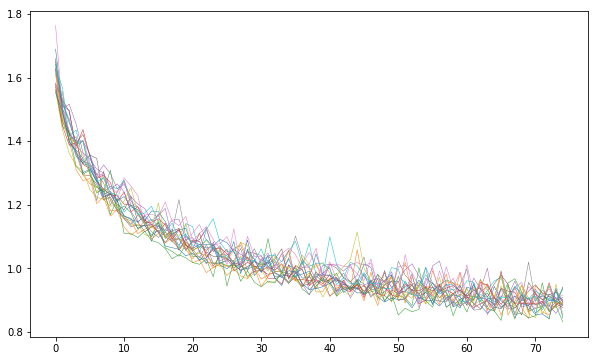

In [7]:
plt.gcf().set_size_inches([10,6])
for hist in histories:
    plt.plot(hist['val_loss'], lw=0.5)

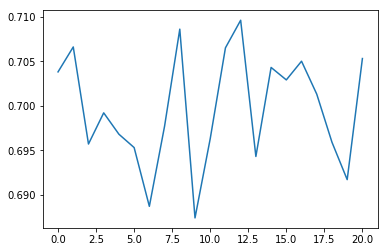

In [8]:
plt.plot([max(hist['val_acc']) for hist in histories])

In [10]:
first_filters = np.array([model.get_weights()[0] for model in models])

(height, width, channels_in, channels_out)

In [11]:
first_filters.shape

(21, 7, 7, 3, 4)

In [12]:
correct_preds = []
for model in models:
    preds = model.predict(x_test)
    correct_preds.append((preds.argmax(axis=1) == y_test.argmax(axis=1)))

In [16]:
dotprod_arr = np.zeros([21, 21])
for i in range(21):
    for j in range(21):
        dotprod_arr[i, j] = np.dot(correct_preds[i].astype(np.int64), correct_preds[j].astype(np.int64)) / 10000

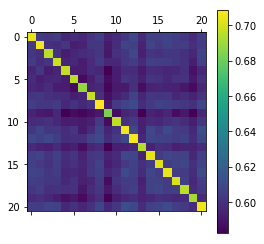

In [17]:
plt.matshow(dotprod_arr)
plt.colorbar()

In [19]:
first_filters.shape

(21, 7, 7, 3, 4)

In [23]:
def scale_filter(arr, flip=False):
    if flip: 
        arr = arr*-1
    arr = arr - arr.min()
    arr /= arr.max()
    return arr

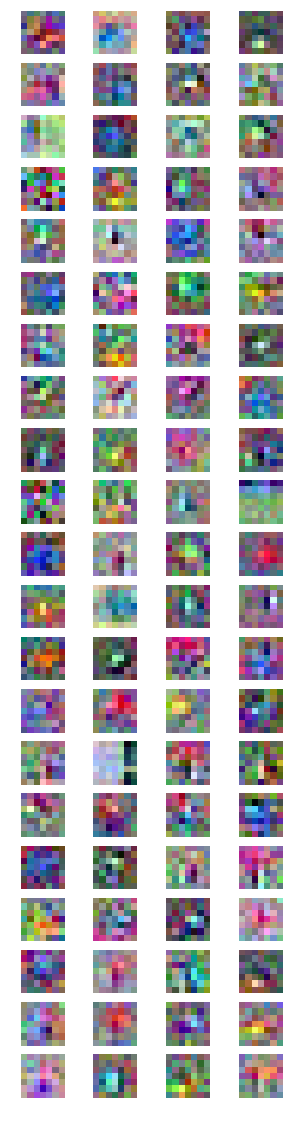

In [39]:
fig, ax = plt.subplots(ncols=4, nrows=21, figsize=[5,20])
for i in range(21):
    for j in range(4):
        ax[i, j].axis('off')
        ax[i, j].imshow(scale_filter(first_filters[i, :, :, :, j]))

In [25]:
def filter_distance(arr1, arr2, return_flip_status=False):
    scaled_filter1 = scale_filter(arr1)
    scaled_filter2 = scale_filter(arr2)
    flipped_filter2 = scale_filter(arr2, flip=True)
    dist = np.abs(scaled_filter1 - scaled_filter2).mean()
    flipped_dist = np.abs(scaled_filter1 - flipped_filter2).mean()
    if return_flip_status:
        return (flipped_dist < dist)
    else:
        return min([dist, flipped_dist])

In [26]:
first_filters[0].shape

(7, 7, 3, 4)

In [29]:
distances = np.zeros([21, 21, 4, 4, 3])
for i in range(21):
    print(i)
    for j in range(21):
        for k in range(4):
            for l in range(4):
                for m in range(3):
                        distances[i, j, k, l, m] = filter_distance(first_filters[i, :, :, m, k], first_filters[j, :, :, m, l])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [30]:
shortest_distances = np.sort(distances[(distances > 0)])[:100:2]
shortest_distances

array([0.12058035, 0.12063674, 0.12932745, 0.13078545, 0.13345757,
       0.13345803, 0.13472679, 0.13683373, 0.13774918, 0.13942468,
       0.14028078, 0.14154334, 0.14252651, 0.14356059, 0.14399979,
       0.14423664, 0.14445627, 0.14512385, 0.14529002, 0.14544758,
       0.14566576, 0.1466002 , 0.14716792, 0.14770401, 0.14815666,
       0.14849174, 0.14885458, 0.14895019, 0.1491542 , 0.14922109,
       0.14969631, 0.15006141, 0.15013394, 0.15118191, 0.15133809,
       0.15189613, 0.15217493, 0.15230167, 0.15254126, 0.15274972,
       0.15299067, 0.1530192 , 0.15337771, 0.15392651, 0.15397213,
       0.15436625, 0.15462287, 0.15541637, 0.15586007, 0.15594384])

0.3567545413970947

In [31]:
arg = np.isclose(0.0293329, distances).argmax()

In [32]:
arg2 = np.unravel_index(arg, (30, 30, 16, 16, 3))

In [33]:
arg2

(0, 0, 0, 0, 0)

IndexError: index 8 is out of bounds for axis 4 with size 4

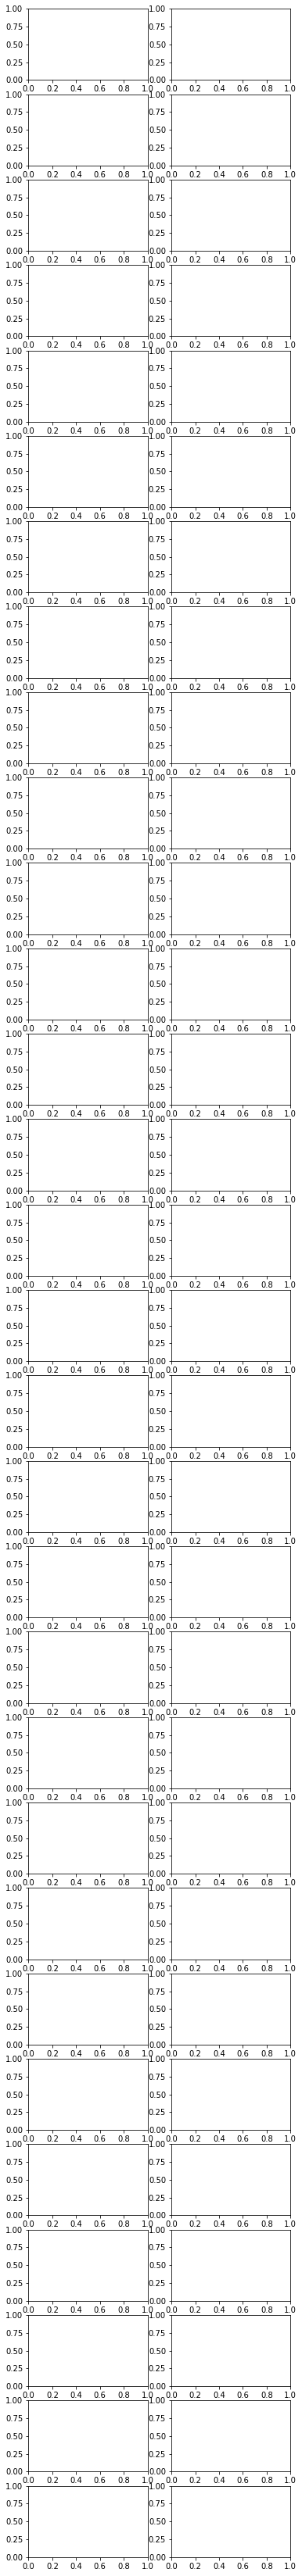

In [34]:
fig, ax = plt.subplots(ncols=2, nrows=30)
fig.set_size_inches([6, 60])

similar_filters = []
for i, dist in enumerate(shortest_distances[:30]):
    arg = (distances == dist).argmax()
    unravelled = np.unravel_index(arg, (30, 30, 16, 16, 3))
    filter1 = first_filters[unravelled[0], :, :, unravelled[4], unravelled[2]]
    filter2 = first_filters[unravelled[1], :, :, unravelled[4], unravelled[3]]
    flip = filter_distance(filter1, filter2, return_flip_status=True)
    filter1 = scale_filter(filter1, flip=flip)
    filter2 = scale_filter(filter2)
    ax[i,0].imshow(filter1, vmin=0, vmax=1)
    ax[i,1].imshow(filter2, vmin=0, vmax=1)

In [ ]:
first_filters.shape

In [ ]:
scaled_filters = []
for i in range(30):
    for j in range(16):
        for k in range(3):
            f = scale_filter(first_filters[i,:,:,k,j])
            f_flip = scale_filter(first_filters[i,:,:,k,j], flip=True)
            scaled_filters.append(f.flatten())
            scaled_filters.append(f_flip.flatten())
scaled_filters = np.array(scaled_filters)

In [ ]:
distances.shape

In [ ]:
distances[0,1,:,0,0]

In [ ]:
plt.plot([min(line) for line in ])